In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms, datasets

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [2]:
@torch.no_grad()
def get_num_corrects(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,kernel_size=5) #1 channel image input and 6 channel image as output using 5x5 kernel
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1,400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x
        

In [4]:
net = LeNet()
net.load_state_dict(torch.load('./Saved_models/Tut1_Lenet_params.pt'),strict=True)
net.train()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
params = list(net.named_parameters())

tot_params = 0
for name, param in params:
    print(name, '--->',param.shape)
    tot_params += np.sum(np.prod(param.size()))
print('\nTot no. of parameters: ',tot_params)

conv1.weight ---> torch.Size([6, 1, 5, 5])
conv1.bias ---> torch.Size([6])
conv2.weight ---> torch.Size([16, 6, 5, 5])
conv2.bias ---> torch.Size([16])
fc1.weight ---> torch.Size([120, 400])
fc1.bias ---> torch.Size([120])
fc2.weight ---> torch.Size([84, 120])
fc2.bias ---> torch.Size([84])
fc3.weight ---> torch.Size([10, 84])
fc3.bias ---> torch.Size([10])

Tot no. of parameters:  61706


In [6]:
apply_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

Batch = 100
train_set = datasets.MNIST(root='./data', train=True, download=False, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Batch, shuffle=True,num_workers=4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [7]:
"""
data = next(iter(train_loader))
inputs,labels = data
#inputs = inputs.unsqueeze(0)
preds = net(inputs)

loss = F.cross_entropy(preds,labels)
loss.item()

loss.backward()
#net.conv2.weight.grad.shape
optimizer.step()
preds = net(inputs)
loss = F.cross_entropy(preds,labels)
loss.item()
"""

'\ndata = next(iter(train_loader))\ninputs,labels = data\n#inputs = inputs.unsqueeze(0)\npreds = net(inputs)\n\nloss = F.cross_entropy(preds,labels)\nloss.item()\n\nloss.backward()\n#net.conv2.weight.grad.shape\noptimizer.step()\npreds = net(inputs)\nloss = F.cross_entropy(preds,labels)\nloss.item()\n'

In [8]:
n = 1
for epoch in range(n):
    tot_loss = 0
    tot_correct = 0
    for data in train_loader:
        inputs,labels = data
        
        preds = net(inputs)
        loss = F.cross_entropy(preds,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_loss += loss.item()
        tot_correct += get_num_corrects(preds,labels) 
    print("epoch: ",epoch,"tot_correct: ",tot_correct,"tot_loss: ",tot_loss)

In [9]:
torch.save(net.state_dict(),'./Saved_models/Tut1_Lenet_params.pt')

In [10]:
@torch.no_grad()
def get_all_preds(net,loader):
    all_preds = torch.Tensor([])
    for batch in loader:
        images,labels = batch

        preds = net(images)
        all_preds = torch.cat((all_preds,preds),dim=0)
    return all_preds

In [11]:
net.eval()
with torch.no_grad():
    pred_loader = torch.utils.data.DataLoader(train_set, batch_size=1000,num_workers=4)
    train_preds = get_all_preds(net,pred_loader)

In [12]:
train_preds.shape

torch.Size([60000, 10])

In [13]:
train_preds.requires_grad

False

In [14]:
tot_correct = get_num_corrects(train_preds,train_set.targets)
print("total correct",tot_correct)
print("accuracy",tot_correct/len(train_set))

total correct 59852
accuracy 0.9975333333333334


In [15]:
stacked = torch.stack((train_set.targets,train_preds.argmax(dim=1)),dim=1)
stacked.shape

torch.Size([60000, 2])

In [16]:
stacked

tensor([[5, 5],
        [0, 0],
        [4, 4],
        ...,
        [5, 5],
        [6, 6],
        [8, 8]])

In [17]:
conf_mat = torch.zeros(10,10, dtype=torch.int32)
conf_mat

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [18]:
for it in stacked:
    t,p = it.tolist()
    conf_mat[t,p] += 1
conf_mat

tensor([[5919,    0,    0,    0,    0,    0,    1,    0,    1,    2],
        [   0, 6731,    1,    0,    0,    0,    0,   10,    0,    0],
        [   1,    1, 5948,    0,    0,    0,    1,    7,    0,    0],
        [   0,    0,    6, 6111,    0,    4,    0,    4,    2,    4],
        [   0,    4,    0,    0, 5827,    0,    3,    1,    0,    7],
        [   3,    0,    0,    6,    1, 5400,    8,    0,    3,    0],
        [   3,    0,    0,    0,    3,    1, 5909,    0,    2,    0],
        [   0,    4,    2,    0,    1,    0,    0, 6254,    2,    2],
        [   2,    1,    4,    2,    2,    2,    2,    1, 5832,    3],
        [   3,    1,    0,    0,    8,    4,    0,    7,    5, 5921]], dtype=torch.int32)

In [19]:
import itertools
import matplotlib.pyplot as plt

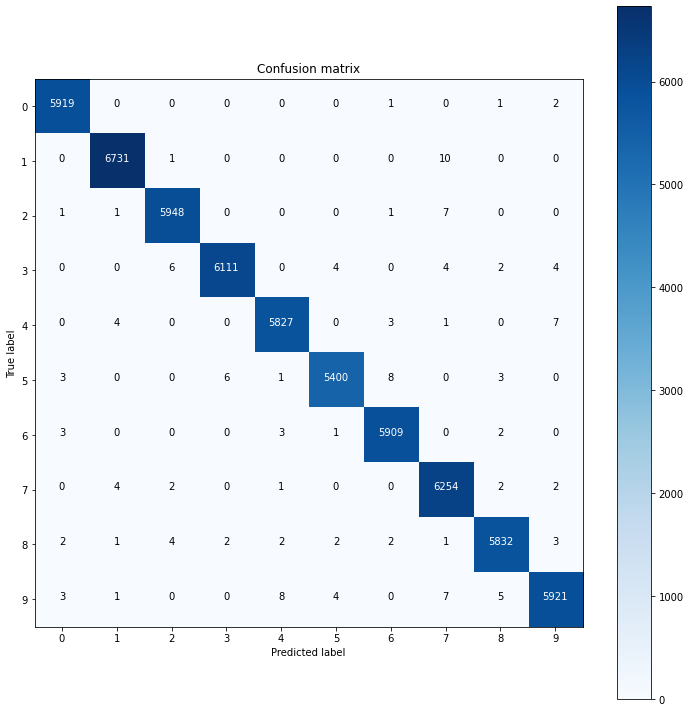

In [20]:
classes = ('0','1','2','3','4','5','6','7','8','9')
plt.figure(figsize=(10,10))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


thresh = conf_mat.max() / 2
for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
    plt.text(j, i, format(conf_mat[i, j]), horizontalalignment="center", color="white" if conf_mat[i, j] > thresh else "black")
